<h1><big><center>Probabilistic Graphical Models - HW1</center></big></h1>
<center>
**Names**: Jean-Christophe CORVISIER - Mohammed Amine KHELDOUNI
</center>
<center>
**Emails**: jean-christophe.corvisier@eleves.enpc.fr - mkheldou@ens-paris-saclay.fr
</center>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

link_of_path = r"./classification_data_HWK1/classification_data_HWK1/"

In [2]:
# Utils functions

def f(X,w):
    return np.dot(X,w)

def sigmoid(X,w):
    return 1./(1+np.exp(-f(X,w)))

In [6]:
class LinearClassification:
    def __init__(self, dataset):
        # Getting the dataset into Train set and Test set
        self.datasetId = dataset
        self.fileTrain = pd.read_csv(os.path.join(link_of_path, "classification" + dataset + ".train"), sep="\t", header = None)
        self.fileTest = pd.read_csv(os.path.join(link_of_path, "classification" + dataset + ".test"), sep="\t", header = None)
        
        self.Xtrain = self.fileTrain[[0,1]]
        self.Xtest = self.fileTest[[0,1]]
        self.ytrain = self.fileTrain[[2]]
        self.ytest = self.fileTest[[2]]
        
        # Proccess and reshape Xtrain,ytrain and Xtest,ytest
        self.ytrain = np.asarray(self.ytrain).reshape((len(self.Xtrain),1))
        self.Xtrain = np.asarray(self.Xtrain)
        self.Xtrain.reshape((len(self.Xtrain),2))
        self.ytest = np.asarray(self.ytest).reshape((len(self.Xtest),1))
        self.Xtest = np.asarray(self.Xtest)
        self.Xtest.reshape((len(self.Xtest),2))
        
    def trainLDA(self):
        N = len(self.Xtrain)
        N1 = np.sum(self.ytrain)
        pi = N1/N
        mu0 = np.dot((1-self.ytrain).transpose(),self.Xtrain)/(N-N1)
        mu1 = np.dot(self.ytrain.transpose(),self.Xtrain)/N1
        
        sigma = 1./N * (np.dot(((1-self.ytrain)*(self.Xtrain-mu0)).transpose(), (self.Xtrain-mu0))+np.dot((self.ytrain*(self.Xtrain-mu1)).transpose(), (self.Xtrain-mu1)))
        return [pi,mu0,mu1,sigma]

    def predictLDA(self,X):
        [pi,mu0,mu1,sigma] = self.trainLDA()
        p_y0 = (1-pi)*np.exp(-0.5*np.sum(np.dot((X-mu0),np.linalg.inv(sigma))*(X-mu0), axis=1))
        p_y1 = pi*np.exp(-0.5*np.sum(np.dot((X-mu1),np.linalg.inv(sigma))*(X-mu1),axis=1))
        prediction = p_y1 >= p_y0
        prediction = prediction.astype(int)
        return prediction
         
    def trainLogReg(self):
        def irlsOptimization(X, y, Niter, epsilon):
            m = X.shape[0]
            d = X.shape[1]
            w = 0*np.ones((d,1))
            counter = 0
            diff = 10*epsilon
            while (counter<Niter and diff > epsilon):
                D = np.diagflat(sigmoid(X,w)*(1-sigmoid(X,w)))
                delta = np.dot(np.dot(np.linalg.pinv(np.dot(np.dot(X.transpose(),D),X)), X.transpose()), (y-sigmoid(X,w)))
                w = w + 1/(counter+1)*delta
                counter += 1
                diff = np.linalg.norm(1/(counter+1)*delta)
            return w
        
        Niter = 2000
        epsilon = 10e-3
        # we stack a column of ones to X to consider b as the first element of w
        X = np.column_stack((np.ones((self.Xtrain.shape[0],1)),self.Xtrain))
        w = irlsOptimization(X,self.ytrain,Niter,epsilon)
        return w
    
    def predictLogReg(self, X):
        w = self.trainLogReg()
        # we stack a column of ones to X to consider b as the first element of w
        X = np.column_stack((np.ones((X.shape[0],1)),X))
        prediction = sigmoid(X,w) >= 1/2
        prediction = prediction.astype(int)
        return prediction.transpose()
              
    def trainLinReg(self):
        def linearRegression(X,y):
            # Computing the classification by a linear regression with the normal equation
            w = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
            Xw = np.dot(X,w)
            sigma_square = np.mean((y - Xw)**(2))
            return w, sigma_square
        X = np.column_stack((np.ones((self.Xtrain.shape[0],1)),self.Xtrain))
        w, sigma_square = linearRegression(X,self.ytrain)
        return w, sigma_square
    
    def predictLinReg(self, X):
        w, sigma_square = self.trainLinReg()
        # we stack a column of ones to X to consider b as the first element of w
        X = np.column_stack((np.ones((X.shape[0],1)),X))
        prediction = X.dot(w) >= 1/2
        return(prediction.transpose())
    
    def trainQDA(self):
        N = len(self.Xtrain)
        N1 = np.sum(self.ytrain)
        
        pi = 1./ N * np.sum(self.ytrain)
        mu0 = np.dot((1-self.ytrain).transpose(),self.Xtrain)/(N-N1)
        mu1 = np.dot(self.ytrain.transpose(), self.Xtrain)/N1

        sigma0 = 1./(N-N1) * np.dot((self.Xtrain-mu0).transpose(), (1-self.ytrain)*(self.Xtrain-mu0))
        sigma1 = 1./N1 * np.dot((self.Xtrain-mu1).transpose(), self.ytrain*(self.Xtrain-mu1))

        return [pi,mu0,mu1,sigma0,sigma1]

    def predictQDA(self, X):
        [pi,mu0,mu1,sigma0,sigma1] = self.trainQDA()
        p_y0 = (1-pi)/np.sqrt(np.linalg.det(sigma0))*np.exp(-0.5*np.sum(np.dot((X-mu0),np.linalg.inv(sigma0))*(X-mu0),axis=1))
        p_y1 = pi/np.sqrt(np.linalg.det(sigma1))*np.exp(-0.5*np.sum(np.dot((X-mu1),np.linalg.inv(sigma1))*(X-mu1),axis=1))
        prediction = p_y1 >= p_y0
        prediction = prediction.astype(int)
        return prediction
    
    def classificationError(self, predictFunction, labelClassifier):
        predictionTrain = predictFunction(self.Xtrain)
        print("Misclassification error for the training set of " + labelClassifier + " (in dataset "+ self.datasetId + "):")
        print(1-np.sum(self.ytrain.transpose()==predictionTrain)/len(self.ytrain))
        predictionTest = predictFunction(self.Xtest)
        print("Misclassification error for the test set of " + labelClassifier + " (in dataset "+ self.datasetId + "):")
        print(1-np.sum(self.ytest.transpose()==predictionTest)/len(self.ytest))
    
    ### Plot methods for (LDA, LogReg, LinReg, QDA)
    def plotClassificationLDA(self, file):
        plt.figure(figsize=(20,10))
        X_y1 = file.loc[file[2]==1]
        X_y0 = file.loc[file[2]==0]        
        [pi,mu0,mu1,sigma] = self.trainLDA()
        
        # Coefficient of the classification boundaries computation:
        vecteur_inter = np.dot(np.linalg.inv(sigma), (mu1 - mu0).T)
        norm_sigma_mu0 = np.dot(mu0, np.dot(np.linalg.inv(sigma), mu0.T))
        norm_sigma_mu1 = np.dot(mu1, np.dot(np.linalg.inv(sigma), mu1.T))
        a = -vecteur_inter[0,0]/vecteur_inter[1,0]
        b = (2*np.log((1-pi)/(pi)) + norm_sigma_mu1[0,0] - norm_sigma_mu0[0,0])/(2*vecteur_inter[1,0])
        plt.ylim(np.min(L.fileTrain[[1]][1])-2,np.max(L.fileTrain[[1]][1])+2)
        plt.scatter(X_y1[0],X_y1[1], color='BLUE',label='Positive examples')
        plt.scatter(X_y0[0],X_y0[1], color='RED', label='Negative examples')
        boundariesX = np.linspace(-8,8,20)
        plt.plot(boundariesX, a*boundariesX+b, color="GREEN", label='classification boundaries', linewidth=2)
        plt.xlabel("First feature of X", fontsize=18)
        plt.ylabel("Second feature of X", fontsize=18)
        plt.legend(fontsize=18)
        plt.draw()
        plt.show()
        
    def plotClassificationLogReg(self, file):
        plt.figure(figsize=(15,8))
        X_y1 = file.loc[file[2]==1]
        X_y0 = file.loc[file[2]==0]
        # w of dimension d+1 (we stacked b in the vector of weights)
        w = self.trainLogReg()
        
        # Computing the classification boundaries
        a = -w[1,0]/w[2,0]
        b = -w[0,0]/w[2,0]
        plt.ylim(np.min(L.fileTrain[[1]][1])-2,np.max(L.fileTrain[[1]][1])+2)
        plt.scatter(X_y1[0],X_y1[1], color='BLUE', label='Positive examples')
        plt.scatter(X_y0[0],X_y0[1], color='RED', label='Negative examples')
        boundariesX = np.linspace(-8,8,20)
        plt.plot(boundariesX, a*boundariesX+b, color="GREEN", label='classification boundaries', linewidth=2)        
        plt.xlabel("First feature of X", fontsize=18)
        plt.ylabel("Second feature of X", fontsize=18)
        plt.legend(fontsize=18)
        plt.draw()
        plt.show()
        
    
    def plotClassificationLinReg(self, file):
        plt.figure(figsize=(20,10))
        X_y1 = file.loc[file[2]==1]
        X_y0 = file.loc[file[2]==0]
        # w of dimension d+1 (we stacked b in the vector of weights)
        w, sigma_square = self.trainLinReg()
        
        a = -w[1,0]/w[2,0]
        b = (0.5-w[0,0])/w[2,0]
        plt.ylim(np.min(L.fileTrain[[1]][1])-2,np.max(L.fileTrain[[1]][1])+2)
        plt.scatter(X_y1[0],X_y1[1], color='BLUE', label='Positive examples')
        plt.scatter(X_y0[0],X_y0[1], color='RED', label='Negative examples')
        boundariesX = np.linspace(-8,8,20)
        plt.plot(boundariesX, a*boundariesX+b, color="GREEN", label='classfication boundaries', linewidth=2)
        plt.xlabel("First feature of X", fontsize=18)
        plt.ylabel("Second feature of X", fontsize=18)
        plt.legend(fontsize=18)
        plt.draw()
        plt.show()
    
    def plotClassificationQDA(self, file):
        plt.figure(figsize=(15,8))
        plt.clf()
        X_y1 = file.loc[file[2]==1]
        X_y0 = file.loc[file[2]==0]
        z = -np.linspace(9,15,100)
        x = np.linspace(-26,26,1000)
        
        [pi, mu0, mu1, sigma0, sigma1] = self.trainQDA()
        d = sigma0.shape[0]
        
        ### Computing the conical equation (classification boundaries)
        # Computing inverse vectors of inv(sigma_i)*mu_i
        sigma_inv_mu0 = np.dot(np.linalg.inv(sigma0), mu0.T)
        sigma_inv_mu1 = np.dot(np.linalg.inv(sigma1), mu1.T)
        
        inv_sigma1 = np.linalg.inv(sigma1)
        inv_sigma0 = np.linalg.inv(sigma0)
        
        a = -inv_sigma1[0,0] + inv_sigma0[0,0]
        b = -2*inv_sigma1[1,0] + 2*inv_sigma0[1,0]
        c = -inv_sigma1[1,1] + inv_sigma0[1,1]
        d = 2*sigma_inv_mu1[0,0] - 2*sigma_inv_mu0[0,0]
        e = 2*sigma_inv_mu1[1,0] - 2*sigma_inv_mu0[1,0]
        f = -2 * np.log((1 - pi)/pi) + np.log(np.linalg.det(sigma0)/np.linalg.det(sigma1)) + np.dot(mu0, sigma_inv_mu0)[0,0] - np.dot(mu1, sigma_inv_mu1)[0,0]   
        
        xx, yy = np.meshgrid(np.linspace(-8, 8, 300), np.linspace(-8, 8, 300))

        plt.ylim(np.min(L.fileTrain[[1]][1])-2,np.max(L.fileTrain[[1]][1])+2)
        plt.scatter(X_y1[0],X_y1[1], color='BLUE', label='Positive examples')
        plt.scatter(X_y0[0],X_y0[1], color='RED', label='Negative examples')
        plt.axhline(0, alpha=.1)
        plt.axvline(0, alpha=.1)
        x = xx
        y = yy
        plt.contour(x, y,(a*x**2 + b*x*y + c*y**2 + d*x + e*y + f), [0], colors='GREEN', label='classification boundaries', linewidths=2)
        plt.xlabel("First feature of X", fontsize=18)
        plt.ylabel("Second feature of X", fontsize=18)
        plt.legend(fontsize=18)
        plt.show()
        plt.draw()
        plt.show()
        


In [7]:
L = LinearClassification("A")
L.classificationError(L.predictLDA, "Linear Discriminant Analysis")
print("_______________________")
L.classificationError(L.predictLogReg, "Logistic Regression")
print("_______________________")
L.classificationError(L.predictLinReg, "Linear Regression")
print("_______________________")
L.classificationError(L.predictQDA, "Quadratic Discriminant Analysis")
print("#############################")
L = LinearClassification("B")
L.classificationError(L.predictLDA, "Linear Discriminant Analysis")
print("_______________________")
L.classificationError(L.predictLogReg, "Logistic Regression")
print("_______________________")
L.classificationError(L.predictLinReg, "Linear Regression")
print("_______________________")
L.classificationError(L.predictQDA, "Quadratic Discriminant Analysis")
print("#############################")
L = LinearClassification("C")
L.classificationError(L.predictLDA, "Linear Discriminant Analysis")
print("_______________________")
L.classificationError(L.predictLogReg, "Logistic Regression")
print("_______________________")
L.classificationError(L.predictLinReg, "Linear Regression")
print("_______________________")
L.classificationError(L.predictQDA, "Quadratic Discriminant Analysis")

Misclassification error for the training set of Linear Discriminant Analysis (in dataset A):
0.0133333333333
Misclassification error for the test set of Linear Discriminant Analysis (in dataset A):
0.02
_______________________
Misclassification error for the training set of Logistic Regression (in dataset A):
0.0
Misclassification error for the test set of Logistic Regression (in dataset A):
0.0346666666667
_______________________
Misclassification error for the training set of Linear Regression (in dataset A):
0.0133333333333
Misclassification error for the test set of Linear Regression (in dataset A):
0.0206666666667
_______________________
Misclassification error for the training set of Quadratic Discriminant Analysis (in dataset A):
0.00666666666667
Misclassification error for the test set of Quadratic Discriminant Analysis (in dataset A):
0.02
#############################
Misclassification error for the training set of Linear Discriminant Analysis (in dataset B):
0.03
Misclassifi

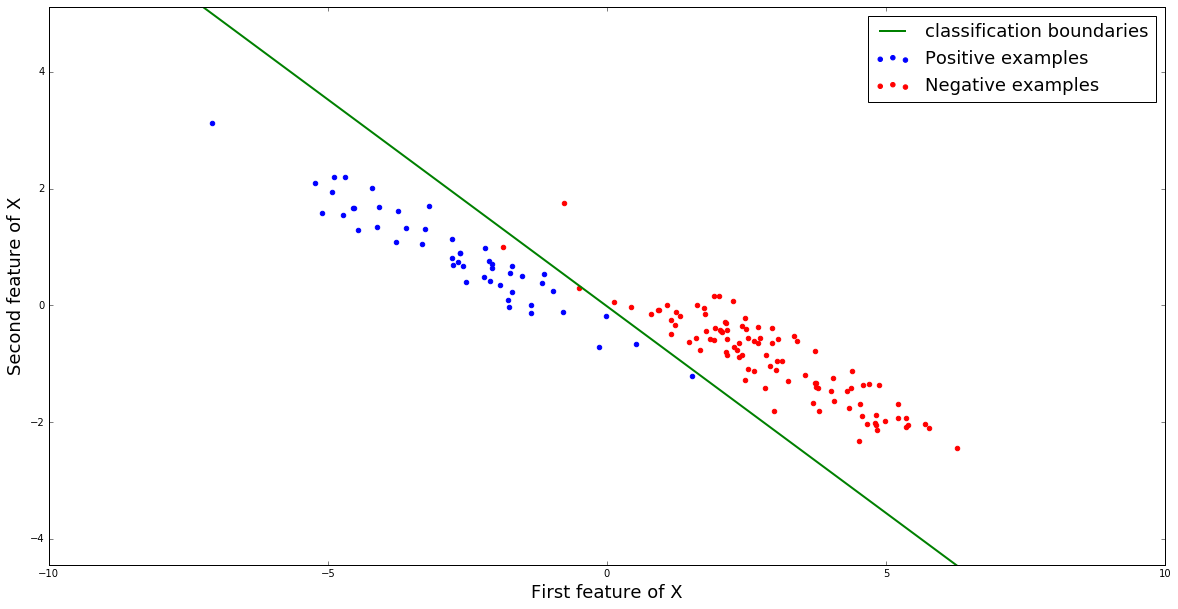

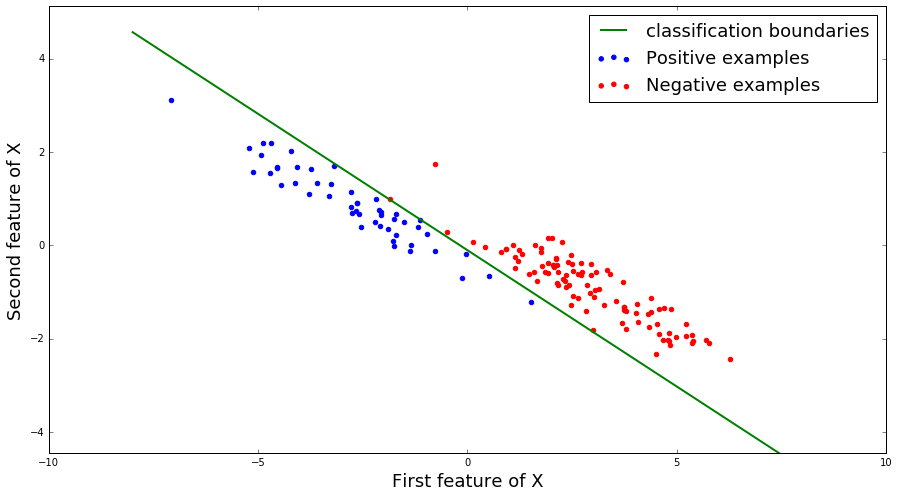

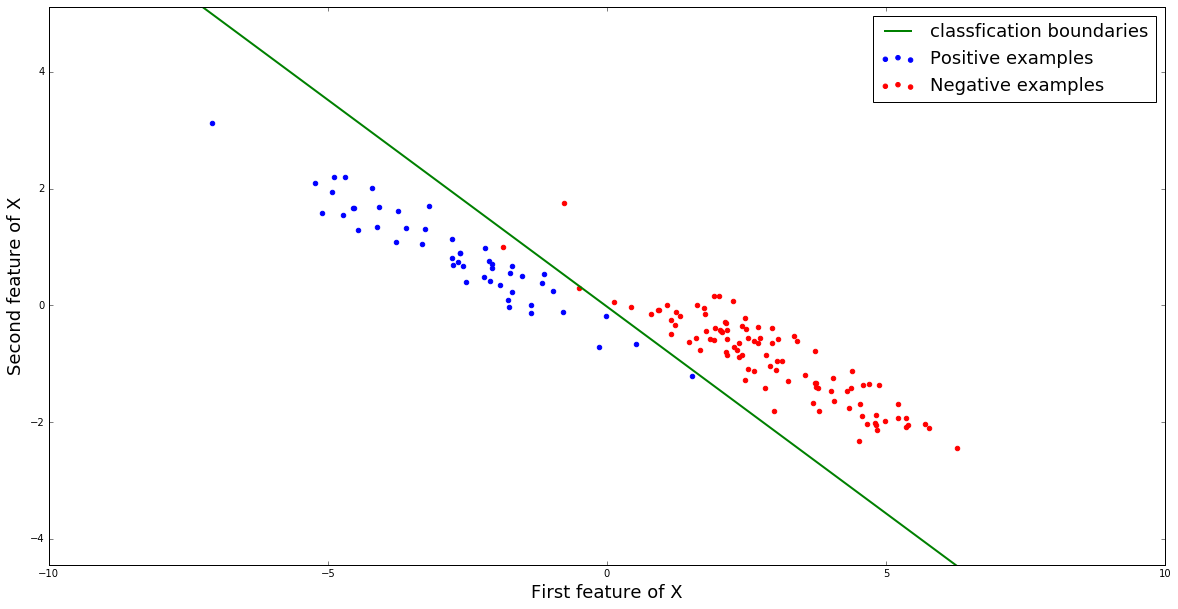

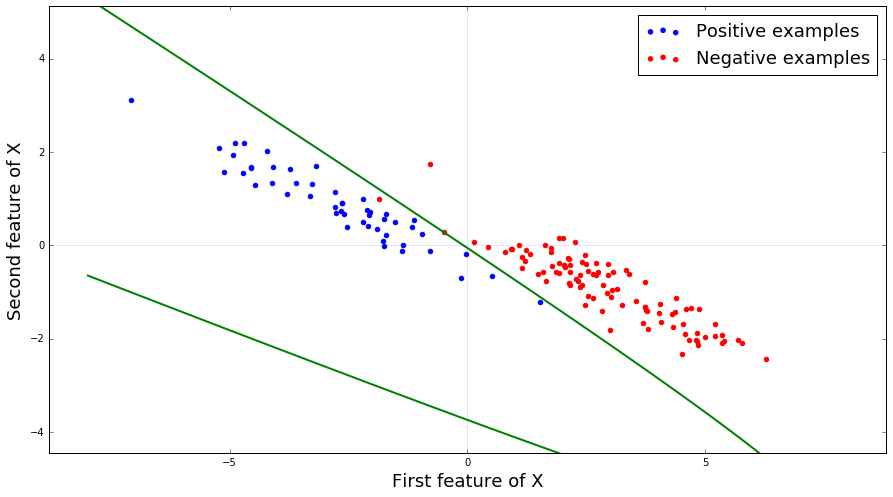

In [18]:
dataId = "A"
# Plotting LDA classification boundaries
L = LinearClassification(dataId)
L.plotClassificationLDA(L.fileTrain)

# Plotting Logistic Regression classification boundaries
L = LinearClassification(dataId)
L.plotClassificationLogReg(L.fileTrain)

# Plotting Linear Regression classification boundaries
L = LinearClassification(dataId)
L.plotClassificationLinReg(L.fileTrain)

# Plotting QDA classification boundaries
L = LinearClassification(dataId)
L.plotClassificationQDA(L.fileTrain)


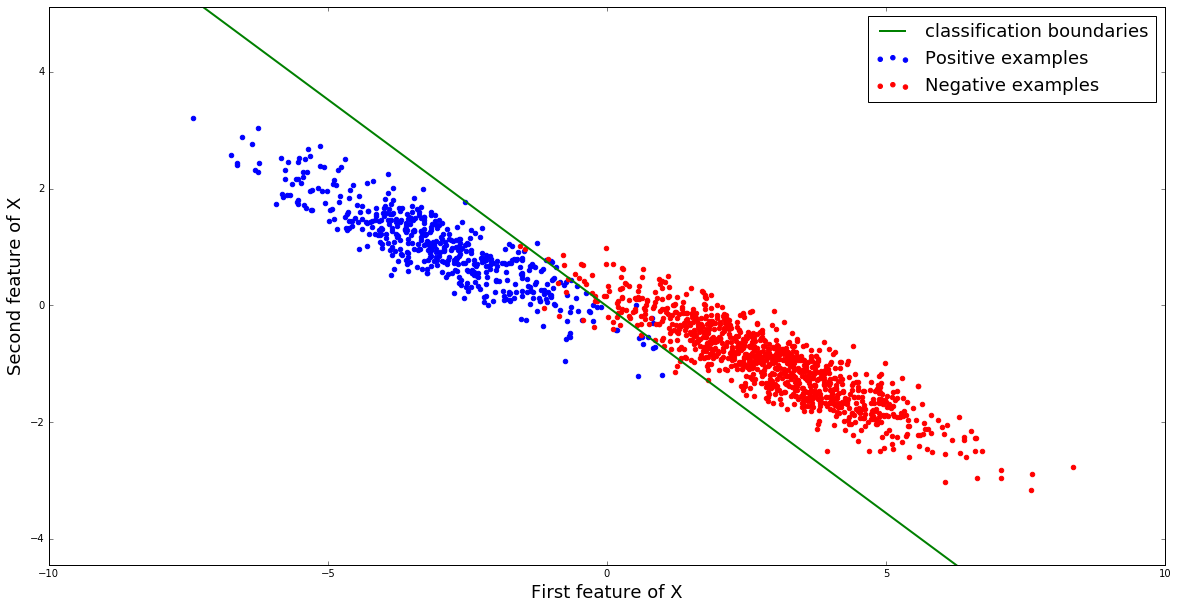

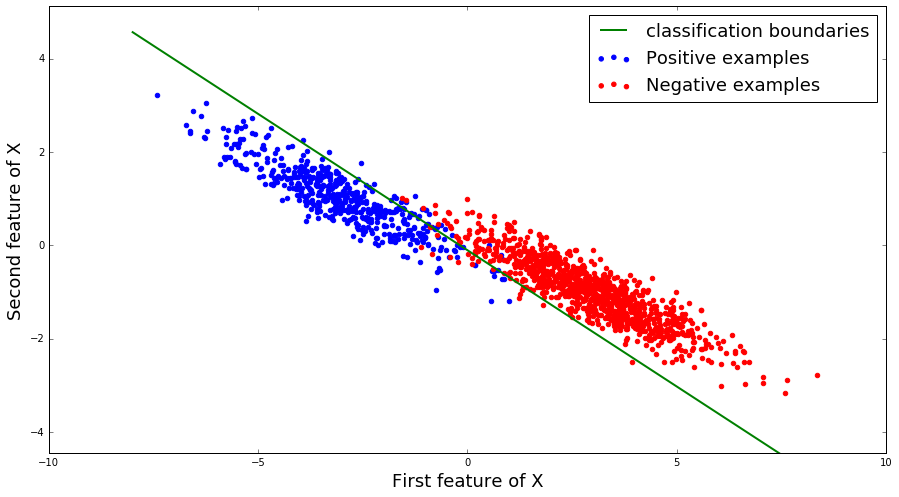

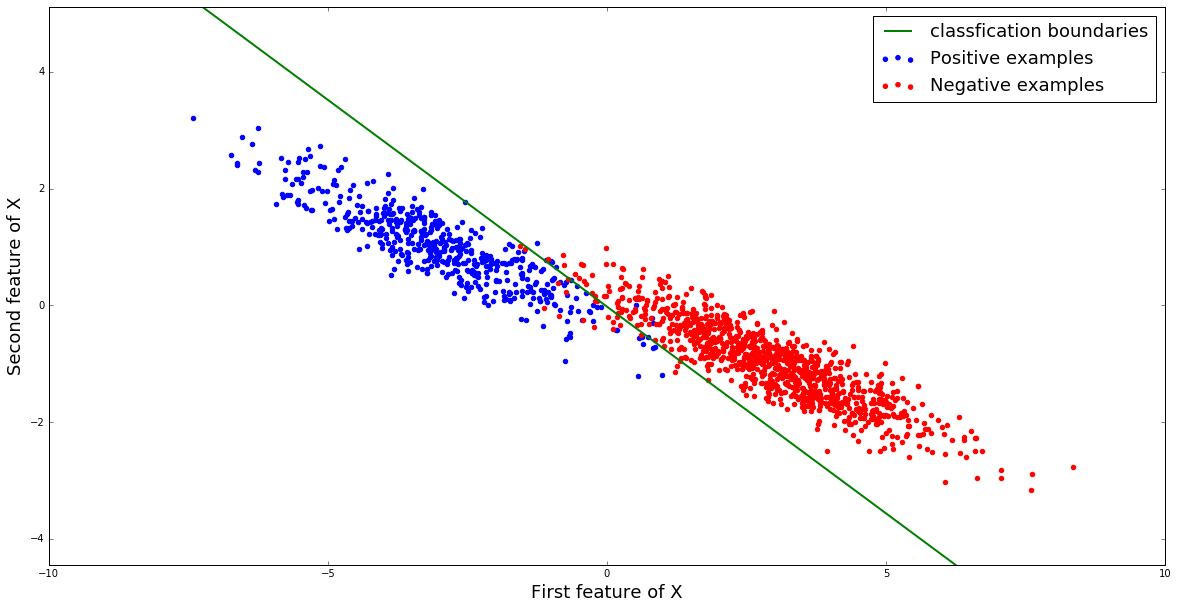

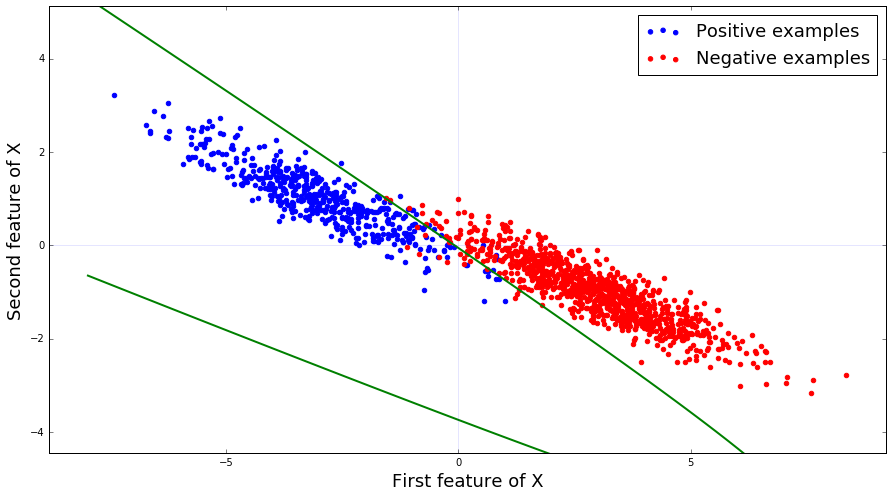

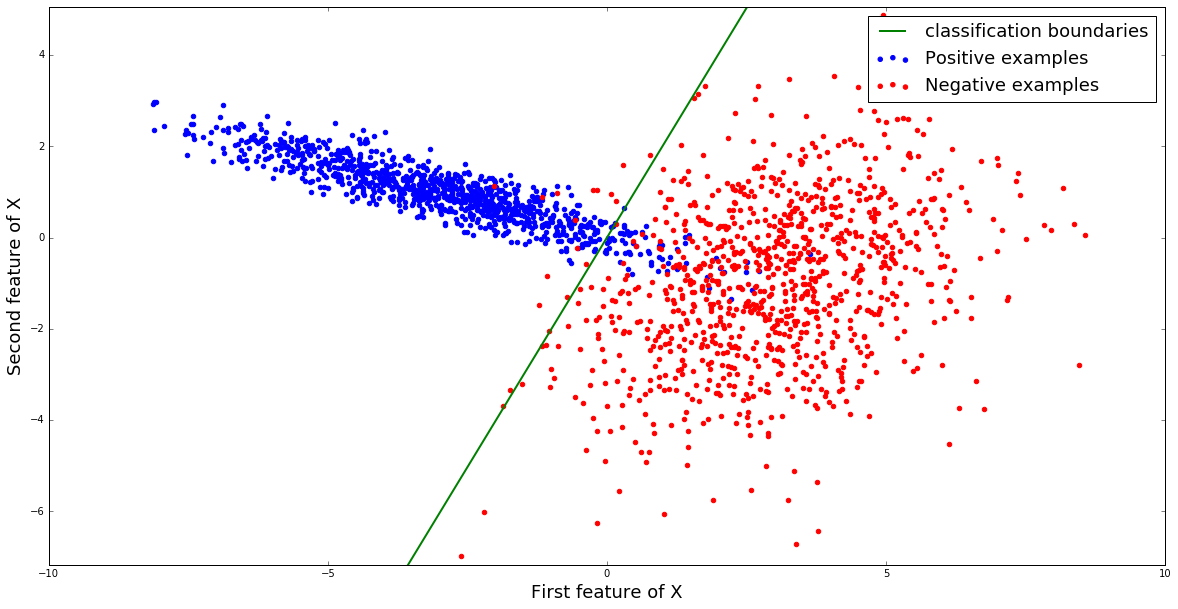

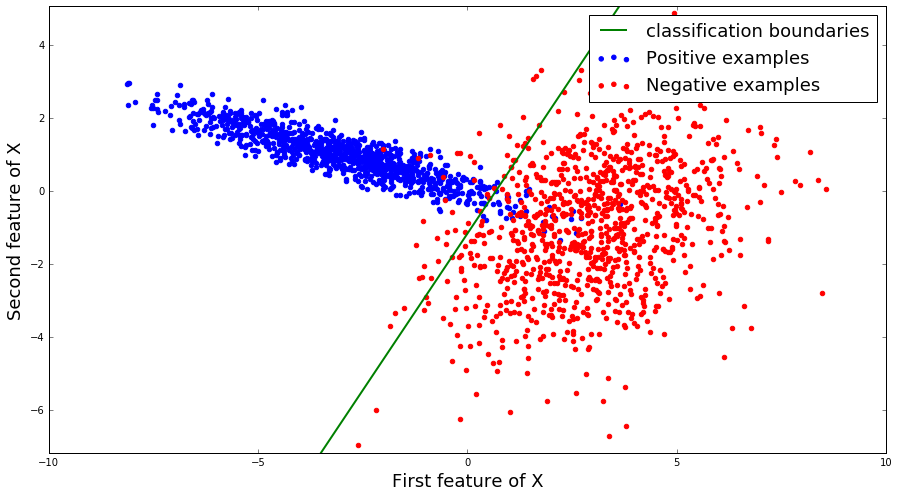

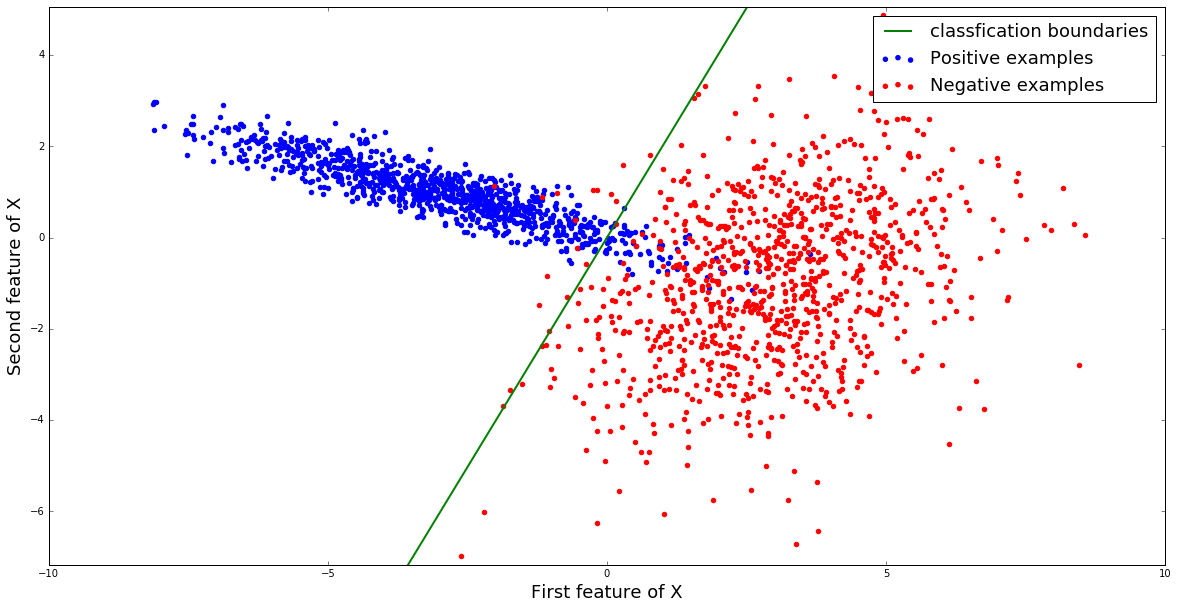

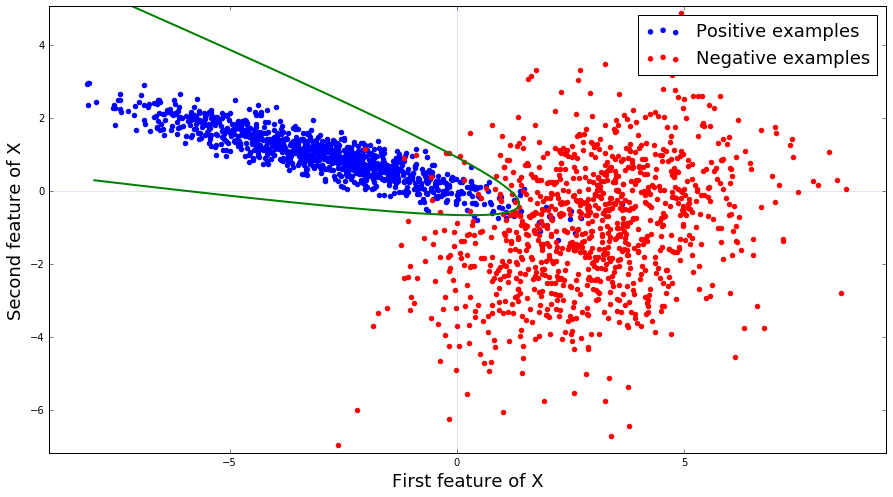

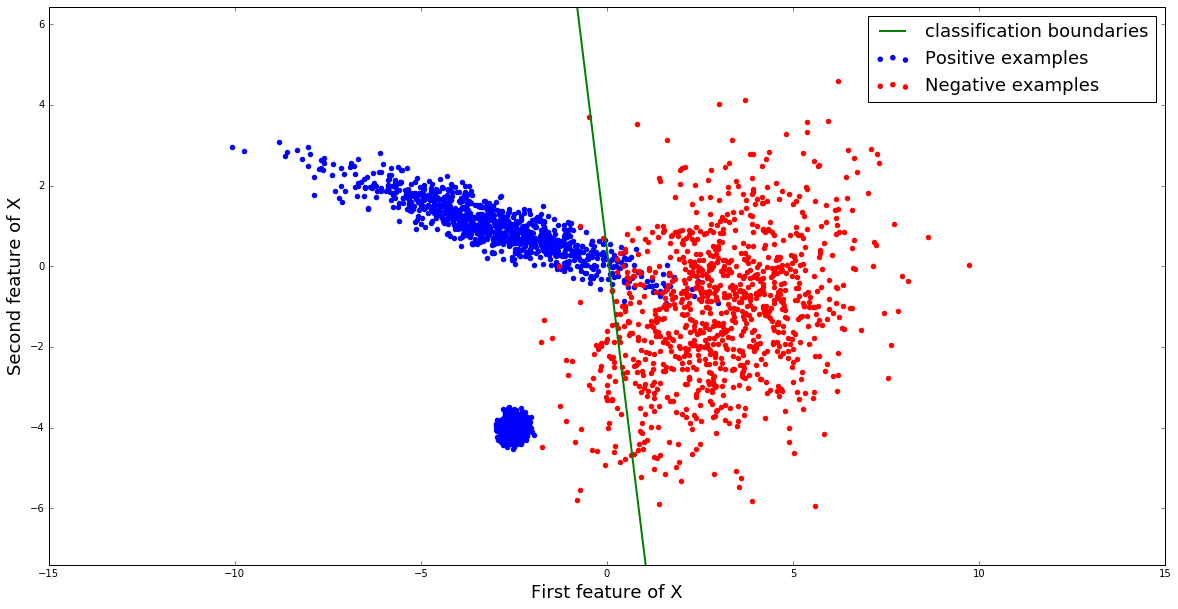

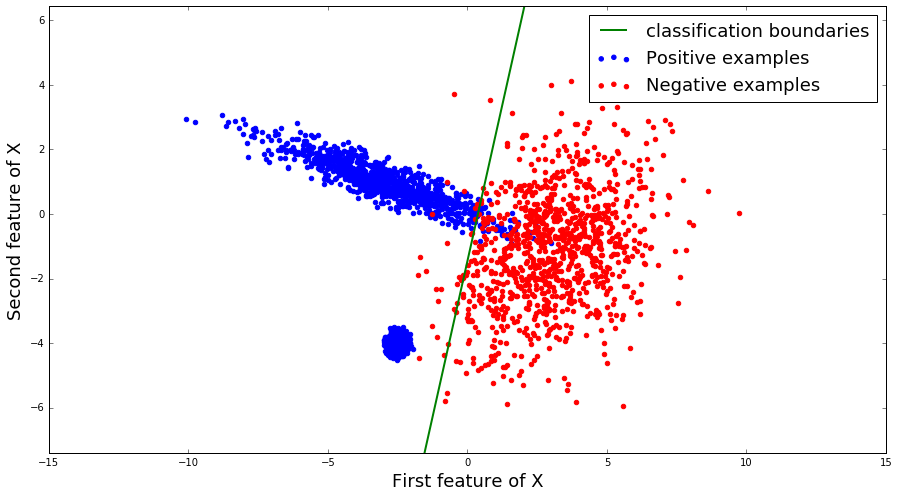

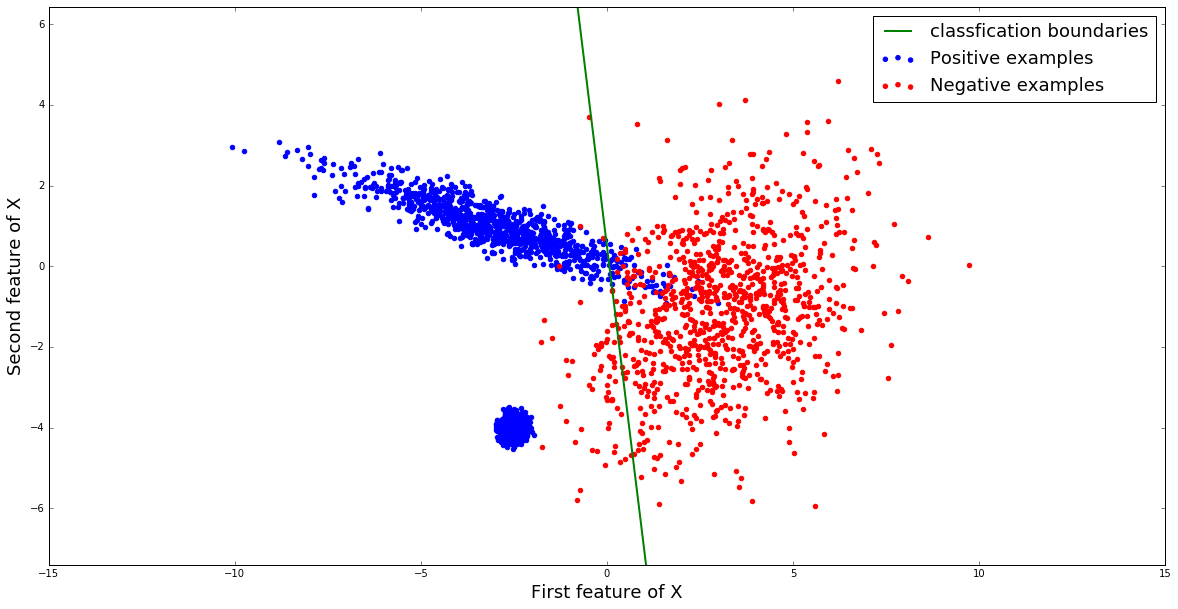

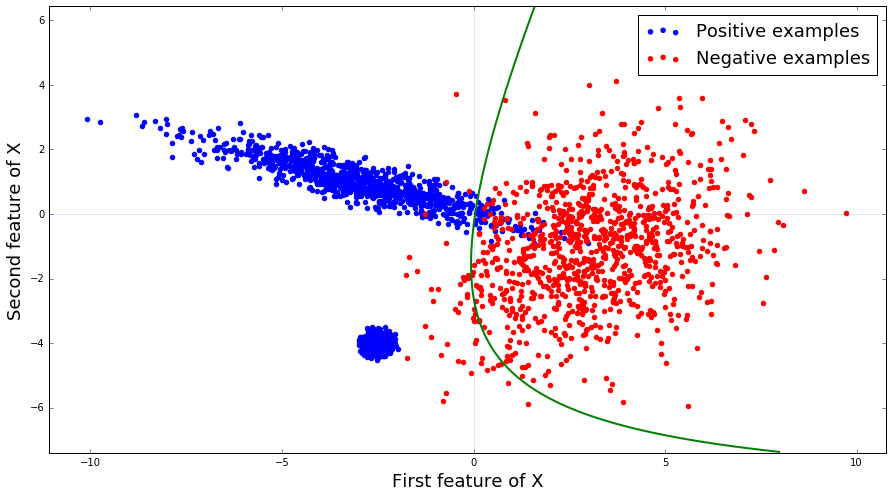

In [16]:
# Plots for test sets
dataId = ["A","B","C"]
for x in dataId:
    # Plotting LDA classification boundaries
    L = LinearClassification(x)
    L.plotClassificationLDA(L.fileTest)

    # Plotting Logistic Regression classification boundaries
    L = LinearClassification(x)
    L.plotClassificationLogReg(L.fileTest)

    # Plotting Linear Regression classification boundaries
    L = LinearClassification(x)
    L.plotClassificationLinReg(L.fileTest)

    # Plotting QDA classification boundaries
    L = LinearClassification(x)
    L.plotClassificationQDA(L.fileTest)